## Incomplete Markets with Aggregate Uncertainty

The Aiyagari model has one very compromising downside:

- Aggregate variables like output, consumption and investment are all constant!

- So we cannot analyze business cycle properties.

Analyzing the business cycle was the contribution of Krusell and Smith (1998).

􏰀But there are alternative shortcuts that have gained popularity

- The general principle is to consider an Aiyagari economy that is at its steady-state in period $t$.

- Then we expose the economy to some temporary shock, under the assumption that the economy will fully have reverted back to its steady-state in period $t + T$.

- Then it’s not that hard to calculate the transition of the economy between period $t$ and $t + T$. Just compute the perfect foresight transition back to steady state!

### Calculating the transition

- General principle: Guess how the capital stock will evolve from period $t + 1$ to period $t + T$ , assuming that
it’s back to it’s steady state value in $t + T + 1$. Call this guess$\{k_{t+s}^0 \}^T_{s=1}$.


- Given this guess, we can calculate wages and interest rates as $w^0_{t+s} = exp(z_{t+s})F_n(k^0_t,n)$ and
$\tilde{r}^0_{t+s} = exp(z_{t+s})F_k(k^0_t,n)$


- 􏰀 Using time iteration again, we can find $\tilde{g}(a, s)$ as
$$u^\prime((1+r^0_{t+s} )a+w^0_{t+s}−\tilde{g}(a,s)) = β(1 + r^0_{t+s+1} \sum_{s^\prime} 􏰇 u^\prime((1 + r^0_{t+s+1} )\tilde{g}(a, s) + w^0_{t+s+1} − g^0_{t+s+1} (\tilde{g}(a, s), s′))p(s′, s)$$


- Then $g^0_{t+s}(a,s) =  max\{\tilde{g}(a,s), \phi  \}$, with $g_{t+T+1}(a,s)= g(a,s)$


- Then for each $g^0_t, g^0){t+1} , ..., g^0_{t+s}$ we can find a transition matrix $M^0_{t+s}$


- Given that we know $ψt (a, s) = ψ(a, s)$, we can update matrix as $ψ^0_{t+s+1} = ψ^0_{t+s} × M^0_{t+s} $, and calculate the implied aggregate asset holdings $A^0_{t+s}$ 


- Finally Then we update our guess for the sequence of capital as 
$\{k^1_{t+s} \}^T_{s=1} = η\{k^0_{t+s} \}^T_{s=1} + (1 − η)\{A^0_{t+s} \}^T_{s=1}$ with $η ∈ (0, 1]$


- And repeat until $||\{k^{n+1}_{t+s}\}^T_{s=1} − \{k^n_{t+s} \}^T_{s=1}||<\epsilon$

escrever motivacao (Krusell summer course Presentation)

### Krusell-Smith (1998) Replication code

In [1]:
# Import all libraries
import numpy as np
from numpy.random import randn
import statsmodels.api as sm
from scipy.optimize import  brentq, root
from scipy.interpolate import RectBivariateSpline, interpn
np.set_printoptions(precision=4, suppress=True)
import pickle
import quantecon as qe
import pandas as pd
import matplotlib.pyplot as plt
from itertools import cycle

In [27]:
# Define Primitives of the KS 98 model
# Saving options
def save_object(obj, filename):
    with open(filename, 'wb') as output:
        pickle.dump(obj, output, pickle.HIGHEST_PROTOCOL)


def gen_params():
    beta = 0.99  # discount factor
    gamma = 1  # utility function parameter
    alpha = 0.36  # share of capital in production function
    delta = 0.025  # depreciation rate
    mu = 0.15  # unemployment benefits as a share of the wage
    l_bar = 1/0.9  # time endowment; normalizes labor supply to 1 in bad state
    k_ss = ((1/beta-(1-delta))/alpha)**(1/(alpha-1))
    return alpha, beta, gamma, delta, mu, l_bar, k_ss


def gen_grid():
    N = 10000  # number of agents for stochastic simulation
    J = 1000  # number of grid points for stochastic simulation
    k_min = 0
    k_max = 1000
    burn_in = 100
    T = 1000 + burn_in
    ngridk = 100
    x = np.linspace(0, 0.5, ngridk)
    tau = 7
    y = (x/np.max(x))**tau
    km_min = 30
    km_max = 50
    k = k_min + (k_max-k_min)*y
    ngridkm = 4
    km = np.linspace(km_min, km_max, ngridkm)
    return (N, J, k_min, k_max, T, burn_in, k, km_min, km_max,  km,
            ngridk, ngridkm)


def shocks_parameters():
    nstates_id = 2    # number of states for the idiosyncratic shock
    nstates_ag = 2    # number of states for the aggregate shock
    ur_b = 0.1        # unemployment rate in a bad aggregate state
    er_b = (1-ur_b)   # employment rate in a bad aggregate state
    ur_g = 0.04       # unemployment rate in a good aggregate state
    er_g = (1-ur_g)   # employment rate in a good aggregate state
    epsilon = np.arange(0, nstates_id)
    delta_a = 0.01
    a = np.array((1-delta_a, 1+delta_a))
    prob = np.array(([0.525, 0.35, 0.03125, 0.09375],
                 [0.038889, 0.836111, 0.002083, 0.122917],
                 [0.09375, 0.03125, 0.291667, 0.583333],
                 [0.009115, 0.115885, 0.024306, 0.850694]))
    return nstates_id, nstates_ag, epsilon, ur_b, er_b, ur_g, er_g, a, prob


def shocks():
    (N, J, k_min, k_max, T, burn_in, k, km_min, km_max,  km, ngridk,
        ngridkm) = gen_grid()
    nstates_id, nstates_ag, epsilon, ur_b, er_b, ur_g, er_g, a, prob = shocks_parameters()
    ag_shock = np.zeros((T, 1))
    id_shock = np.zeros((T, N))
    np.random.seed(0)

    # ag_shock = np.zeros((T, 1))
    # Transition probabilities between aggregate states
    prob_ag = np.zeros((2, 2))
    prob_ag[0, 0] = prob[0, 0]+prob[0, 1]
    prob_ag[1, 0] = 1-prob_ag[0, 0] # bad state to good state
    prob_ag[1, 1] = prob[2, 2]+prob[2, 3]
    prob_ag[0, 1] = 1-prob_ag[1, 1]

    P = prob/np.kron(prob_ag, np.ones((2, 2)))
    # generate aggregate shocks
    mc = qe.MarkovChain(prob_ag)
    ag_shock = mc.simulate(ts_length=T, init=0)  # start from bad state
    # generate idiosyncratic shocks for all agents in the first period
    draw = np.random.uniform(size=N)
    id_shock[0, :] = draw>ur_b #set state to good if probability exceeds ur_b

    # generate idiosyncratic shocks for all agents starting in second period
    draw = np.random.uniform(size=(T-1, N))
    for t in range(1, T):
        # Fix idiosyncratic itransition matrix conditional on aggregate state
        transition = P[2*ag_shock[t-1]: 2*ag_shock[t-1]+2, 2*ag_shock[t]: 2*ag_shock[t]+2]
        transition_prob = [transition[int(id_shock[t-1, i]), int(id_shock[t-1, i])] for i in range(N)]
        check = transition_prob>draw[t-1, :] #sign whether to remain in current state
        id_shock[t, :] = id_shock[t-1, :]*check + (1-id_shock[t-1, :])*(1-check)
    return id_shock, ag_shock

def convergence_parameters(nstates_ag=2):
    dif_B = 10**10 # difference between coefficients B of ALM on succ. iter.
    criter_k = 1e-8
    criter_B = 1e-6
    update_k = 0.77
    update_B = 0.3
    B = np.array((0,1))*np.ones((nstates_ag, 1))
    return B, dif_B, criter_k, criter_B, update_k, update_B

In [28]:
# Solve the individual problem

def individual(k_prime, B):
    dif_B, criter_k, criter_B, update_k, update_B = convergence_parameters()[1:]
    (N, J, k_min, k_max, T, burn_in, k, km_min, km_max,  km, ngridk,
        ngridkm) = gen_grid()
    alpha, beta, gamma, delta, mu, l_bar, k_ss = gen_params()
    nstates_id, nstates_ag, epsilon, ur_b, er_b, ur_g, er_g, a, prob = shocks_parameters()
    e = np.array((er_b, er_g))
    u = 1-e
    replacement = np.array((mu, l_bar)) #replacement rate of wage
    #Tax rate depending on aggregate and idiosyncratic states

    #Transition probabilities by current state (k,km, Z, eps) and future (Z', eps')
    n = ngridk*ngridkm*nstates_ag*nstates_id
    P = np.zeros((ngridk, ngridkm, nstates_ag, nstates_id, nstates_ag*nstates_id))
    for z in range(nstates_ag*nstates_id):
        for i in range(nstates_ag):
            for j in range(nstates_id):
                P[:, :, i, j, z] = prob[2*i+j, z]*np.ones((ngridk, ngridkm))
    P = P.reshape((n, nstates_ag*nstates_id))

    k_indices = np.zeros(n)
    km_indices = np.zeros(n)
    ag = np.zeros(n)
    e_i = np.zeros(n)
    for s_i in range(n):
        k_indices[s_i], km_indices[s_i], ag[s_i], e_i[s_i] = np.unravel_index(s_i, (ngridk, ngridkm, nstates_ag, nstates_id))
    k_indices = np.asarray([int(x) for x in k_indices])
    km_indices = np.asarray([int(x) for x in km_indices])
    ag = np.asarray([int(x) for x in ag])
    e_i = np.asarray([int(x) for x in e_i])

    """
    Using indices, generate arrays for productivity, employment, aggregate
    capital, individual capital
    """

    Z = np.asarray([a[int(i)] for i in ag])
    L = np.asarray([e[int(i)] for i in ag])
    K = np.asarray([km[int(i)] for i in km_indices])
    k_i = np.asarray([k[int(i)] for i in k_indices])
    irate = alpha*Z*(K/(l_bar*L))**(alpha-1)
    wage = (1-alpha)*Z*(K/(l_bar*L))**alpha
    wealth = irate*k_i + (wage*e_i)*l_bar + mu*(wage*(1-e_i))+(1-delta)*k_i-mu*(wage*(1-L)/L)*e_i
    # Transition of capital depends on aggregate state
    K_prime = np.asarray([np.exp(B[ag[i], 0] + B[ag[i], 1]*np.log(K[i])) for i in range(n)])

    # restrict km_prime to fall into bounds
    K_prime = np.minimum(K_prime, km_max)
    K_prime = np.maximum(K_prime, km_min)

    # future interest rate and wage conditional on state (bad or good aggregate state)
    irate = np.zeros((n, nstates_ag))
    wage = np.zeros((n, nstates_ag))
    for i in range(nstates_ag):
        irate[:, i] = alpha*a[i]*((K_prime/(e[i]*l_bar))**(alpha-1))
        wage[:, i] = (1-alpha)*a[i]*((K_prime/(e[i]*l_bar))**alpha)

    # Tax rate
    tax = np.zeros((n, nstates_ag, nstates_id))
    for i in range(nstates_ag):
        for j in range(nstates_id):
            tax[:, i, j] = j*(mu*wage[:, i]*u[i]/(1-u[i]))
    # Solving the individual problem

    def iterate_policy(k_prime):
        dif_k = 1
        while dif_k > criter_k:
            """
             interpolate policy function k'=k(k, km) in new points (k', km')
            """
            k2_prime = np.zeros((n, nstates_ag, nstates_id))
            c_prime = np.zeros((n, nstates_ag, nstates_id))
            mu_prime = np.zeros((n, nstates_ag, nstates_id))
            #reshape k_prime for interpolation
            k_prime_reshape = k_prime.reshape((ngridk, ngridkm, nstates_id, nstates_ag))
            K_prime_reshape = K_prime.reshape((ngridk, ngridkm, nstates_id, nstates_ag))
            for i in range(nstates_ag):
                for j in range(nstates_id):
                    # capital in aggregate state i, idiosyncratic state j as a function of current states
                    k2_prime[:, i, j] = RectBivariateSpline(k, km, k_prime_reshape[:, :, i, j]).ev(k_prime_reshape, K_prime_reshape).reshape(n)
                    c_prime[:, i, j] = (irate[:, i]*k_prime + replacement[j]*(wage[:, i])
                    +(1-delta)*k_prime-k2_prime[:, i, j]-tax[:, i, j])
                    # replace negative consumption by very low positive number
            c_prime = np.maximum(c_prime, 10**(-10))
            mu_prime = c_prime**(-gamma)

            #Expectation term in Euler equation
            #Components in terms of all possible transitions
            expec_comp = np.zeros((n, nstates_ag, nstates_id))
            for i in range(nstates_ag):
                for j in range(nstates_id):
                    expec_comp[:, i, j] = (mu_prime[:, i, j]*(1-delta + irate[:, i]))*P[:, 2*i+j]
            """
            Expectation term in the Euler equation
             sum over various transitions (which have already been scaled by their probability)
            """
            expec = sum(expec_comp[:, i, j] for i in range(nstates_ag) for j in range(nstates_id))
            # current consumption from Euler equation if borrowing constraint is not binding
            cn = (beta*expec)**(-1/gamma)
            k_prime_n = wealth-cn
            k_prime_n = np.minimum(k_prime_n, k_max)
            k_prime_n = np.maximum(k_prime_n, k_min)
            """
            difference between new and previous capital functions
            """
            dif_k = np.linalg.norm(k_prime_n-k_prime)
            k_prime = update_k*k_prime_n + (1-update_k)*k_prime  # update k_prime_n
        c = wealth - k_prime
        return k_prime, c
    return iterate_policy(k_prime)

In [29]:
# Compute aggregate state
def aggregate_st(k_cross, k_prime, id_shock, ag_shock):
    (N, J, k_min, k_max, T, burn_in, k, km_min, km_max,  km, ngridk,
     ngridkm) = gen_grid()
    nstates_id, nstates_ag, epsilon, ur_b, er_b, ur_g, er_g, a, prob = shocks_parameters()
    km_series = np.zeros((T,1))
    for t in range(T):
        """
        find t-th obs. by computing mean of t-th period cross sectional
        distribution of capital
        """
        km_series[t] = np.mean(k_cross)
        km_series[t] = np.minimum(km_series[t], km_max)
        km_series[t] = np.maximum(km_series[t], km_min)
        """
        To find km_series[t+1], we should compute a new cross sectional distribution
        at t+1.
        1) Find k_prime by interpolation for realized km_series[t] and agg. shock
        2) Compute new kcross by interpolation given previous kcross and id.shock
        """
        # Stack sampling points for interpolation as len(k)*len(epsilon) x 4
        # arr stores the coordinates of the sampling points: k rows, 4 columns
        interp_points = np.array(np.meshgrid(k, km_series[t], ag_shock[t], epsilon))
        interp_points = np.rollaxis(interp_points, 0, 5)
        interp_points = interp_points.reshape((len(k)*len(epsilon), 4))

        k_prime_t4 = interpn(points=(k, km, epsilon, epsilon), values=k_prime.reshape(ngridk, ngridkm, nstates_ag, nstates_id),
                             xi=interp_points).reshape(ngridk, nstates_id)
        # 4-dimensional capital function at time t is obtained by fixing known
        # km_series[t] and ag_shock
        interp_points = np.vstack((k_cross, id_shock[t,:])).T
        """
        given k_cross and idiosyncratic shocks, compute k_cross_n
        """
        k_cross_n = interpn(points=(k, epsilon), values= k_prime_t4.reshape(ngridk, nstates_id),
                            xi= interp_points)
        # restrict k_cross to be within [k_min, k_max]
        k_cross_n = np.minimum(k_cross_n, k_max)
        k_cross_n = np.maximum(k_cross_n, k_min)
        k_cross = k_cross_n
    return km_series, k_cross

In [30]:
# SOLVE IT!
def solve_ALM():
    # generate shocks, grid, parameters, and convergence parameters
    id_shock, ag_shock = shocks()
    (N, J, k_min, k_max, T, burn_in, k, km_min, km_max,  km, ngridk,
        ngridkm) = gen_grid()
    alpha, beta, gamma, delta, mu, l_bar, k_ss = gen_params()
    nstates_id, nstates_ag, epsilon, ur_b, er_b, ur_g, er_g, a, prob = shocks_parameters()
    B, dif_B, criter_k, criter_B, update_k, update_B = convergence_parameters()

    k_prime = 0.9*k
    n = ngridk*ngridkm*nstates_ag*nstates_id
    k_prime = k_prime.reshape((len(k_prime), 1, 1, 1))
    k_prime = np.ones((ngridk, ngridkm, nstates_ag, nstates_id))*k_prime
    k_prime = k_prime.reshape(n)
    k_cross = np.repeat(k_ss, N)
    
    """
    Main loop
    Solve for HH problem given ALM
    Generate time series km_ts given policy function
    Run regression and update ALM
    Iterate until convergence
    """
    iteration = 0
    while dif_B > criter_B:
        # Solve for HH policy functions at a given law of motion
        k_prime, c = individual(k_prime, B)
        # Generate time series and cross section of capital
        km_ts, k_cross_1 = aggregate_st(k_cross, k_prime, id_shock, ag_shock)
        """
        run regression: log(km') = B[j,1]+B[j,2]log(km) for aggregate state
        """
        x = np.log(km_ts[burn_in:(T-1)]).flatten()
        X = pd.DataFrame([np.ones(len(x)), ag_shock[burn_in:(T-1)], x, ag_shock[burn_in:(T-1)]*x]).T
        y = np.log(km_ts[(burn_in+1):]).flatten()
        reg = sm.OLS(y, X).fit()
        B_new = reg.params
        B_mat = np.array((B_new[0], B_new[2], B_new[0]+B_new[1], B_new[2]+B_new[3])).reshape((2, 2))
        dif_B = np.linalg.norm(B_mat-B)
        print(dif_B)

        """
        To ensure that the initial capital distribution comes from the ergodic set,
        we use the terminal distribution of the current iteration as the initial distribution for
        subsequent iterations.

        When the solution is sufficiently accurate, we stop the updating and hold the distribution
        k_cross fixed for the remaining iterations
        """
        if dif_B > (criter_B*100):
            k_cross = k_cross_1 #replace cross-sectional capital distribution

        B = B_mat*update_B + B*(1-update_B) #update the vector of ALM coefficients
        iteration += 1
    return B, km_ts, k_cross, k_prime, c, id_shock, ag_shock

In [31]:
from time import time
start = time()
B, km_ts, k_cross, k_prime, c, id_shock, ag_shock = solve_ALM()
end = time()
print(end - start)

0.6730115911878748
0.027245347185004255
0.006215945303054447
0.0036783181118935494
0.0017676568071757143
0.0010982009191384272
0.0007929428690167732
0.0005844184584124568
0.00043974977074030314
0.0003323296247658779
0.000253264303160224
0.0001944830252355943
0.00015058140451603764
0.00011746259187723351
9.22776656954517e-05
4.498295928935559e-05
2.376181382384631e-05
1.311756804172898e-05
7.648723851144946e-06
4.723516164527723e-06
3.0612849456421494e-06
2.0509772302394466e-06
1.401134820385029e-06
9.668466089166411e-07
177.56517720222473


In [32]:
# Figure comparing implied law of motion for aggregate capital stock and
# actual law of motion


def accuracy_figure(km_ts, ag_shock):
    T = len(km_ts)
    km_alm = np.zeros((T))
    km_alm[0] = km_ts[0]
    for i in range(0, T-1):
        km_alm[i+1] = np.exp(B[ag_shock[i], 0] + B[ag_shock[i], 1]*np.log(km_alm[i]))

    fig, ax = plt.subplots(figsize=(9, 6))
    ax.plot(km_ts, label='Implied by policy rule')
    ax.plot(km_alm, label='Aggregate law of motion')
    ax.set_xlabel('Time')
    ax.set_ylabel('Aggregate capital stock')
    ax.legend(loc='best')
    plt.show()


#Capital accumulation policy function

def plot_policy(k_prime, km_ts):
    (N, J, k_min, k_max, T, burn_in, k, km_min, km_max,  km,
            ngridk, ngridkm) = gen_grid()
    nstates_id, nstates_ag, epsilon, ur_b, er_b, ur_g, er_g, a, prob = shocks_parameters()
    k_prime = k_prime.reshape((ngridk, ngridkm, nstates_ag, nstates_id))
    nstates_id, nstates_ag = shocks_parameters()[0:2]
    percentiles = [0.1, 0.25, 0.75, 0.9]
    km_percentiles = np.percentile(km_ts, percentiles)
    km_cycler = cycle(km_percentiles)
    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))
    for a in range(len(km_percentiles)):
        m, n = np.unravel_index(a, (2, 2))
        for i in range(nstates_ag):
            for j in range(nstates_id):
                ax[m, n].plot(k[0: 40], RectBivariateSpline(k, km, k_prime[:, :, i, j]).ev(k[0:40],
                        next(km_cycler)), label='Aggregate state = %s, Employment = %s' % (i,j))
                ax[m, n].set_xlabel('Capital accumulation: percentile = %s' % (percentiles[a]))
                ax[m, n].legend(loc='best', fontsize=8)
    plt.show()

In [1]:
%config InlineBackend.figure_format = 'retina'
accuracy_figure(km_ts, ag_shock)

NameError: name 'accuracy_figure' is not defined

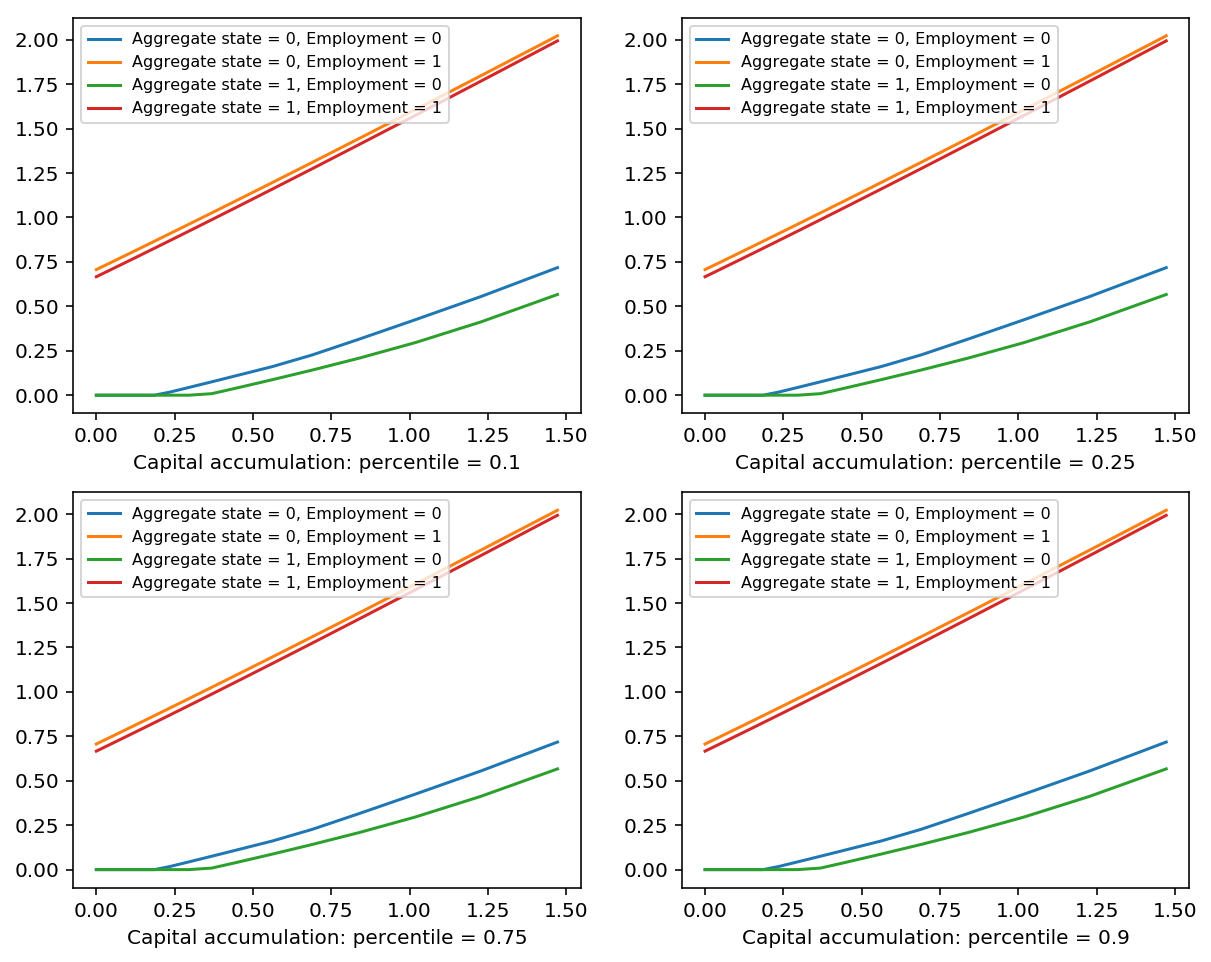

In [35]:
plot_policy(k_prime, km_ts)

Lets do it one iteration at a time to gain intuiton on whats going on.

In [104]:
def solve_ALM_1():
    # generate shocks, grid, parameters, and convergence parameters
    id_shock, ag_shock = shocks()
    (N, J, k_min, k_max, T, burn_in, k, km_min, km_max,  km, ngridk,
        ngridkm) = gen_grid()
    alpha, beta, gamma, delta, mu, l_bar, k_ss = gen_params()
    nstates_id, nstates_ag, epsilon, ur_b, er_b, ur_g, er_g, a, prob = shocks_parameters()
    B, dif_B, criter_k, criter_B, update_k, update_B = convergence_parameters()

    k_prime = 0.9*k
    n = ngridk*ngridkm*nstates_ag*nstates_id
    k_prime = k_prime.reshape((len(k_prime), 1, 1, 1))
    k_prime = np.ones((ngridk, ngridkm, nstates_ag, nstates_id))*k_prime
    k_prime = k_prime.reshape(n)
    k_cross = np.repeat(k_ss, N)
    
    """
    Main loop
    Solve for HH problem given ALM
    Generate time series km_ts given policy function
    Run regression and update ALM
    Iterate until convergence
    """
    iteration = 0
    #while dif_B > criter_B:
    # Solve for HH policy functions at a given law of motion
    k_prime, c = individual(k_prime, B)
    # Generate time series and cross section of capital
    km_ts, k_cross_1 = aggregate_st(k_cross, k_prime, id_shock, ag_shock)
    """
    run regression: log(km') = B[j,1]+B[j,2]log(km) for aggregate state
    """
    x = np.log(km_ts[burn_in:(T-1)]).flatten()
    X = pd.DataFrame([np.ones(len(x)), ag_shock[burn_in:(T-1)], x, ag_shock[burn_in:(T-1)]*x]).T
    y = np.log(km_ts[(burn_in+1):]).flatten()
    reg = sm.OLS(y, X).fit()
    B_new = reg.params
    B_mat = np.array((B_new[0], B_new[2], B_new[0]+B_new[1], B_new[2]+B_new[3])).reshape((2, 2))
    dif_B = np.linalg.norm(B_mat-B)
    print(dif_B)

    """
    To ensure that the initial capital distribution comes from the ergodic set,
    we use the terminal distribution of the current iteration as the initial distribution for
    subsequent iterations.

    When the solution is sufficiently accurate, we stop the updating and hold the distribution
    k_cross fixed for the remaining iterations
    """
    if dif_B > (criter_B*100):
        k_cross = k_cross_1 #replace cross-sectional capital distribution

    B = B_mat*update_B + B*(1-update_B) #update the vector of ALM coefficients
    iteration += 1
    return B, km_ts, k_cross, k_prime, c, id_shock, ag_shock

In [105]:
B, km_ts, k_cross, k_prime, c, id_shock, ag_shock = solve_ALM_1()
print(B)

0.6730115911878748
[[0.1345 0.9632]
 [0.141  0.962 ]]


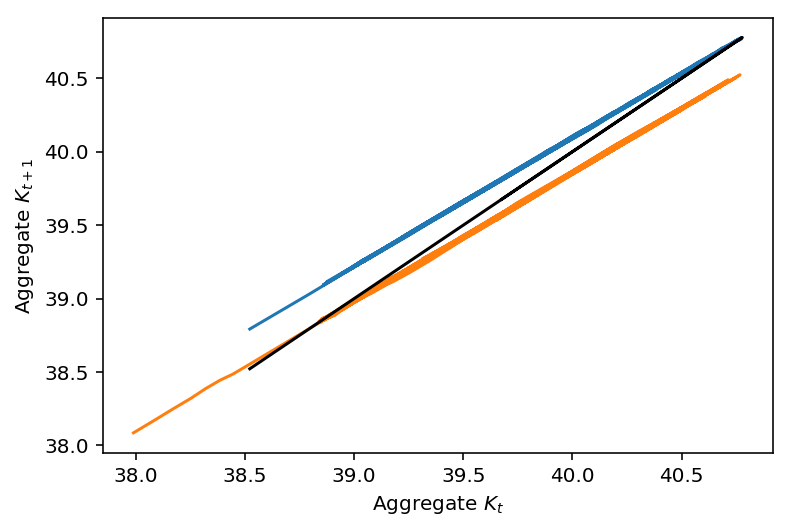

In [106]:
# Agg Today
km_t = np.delete(km_ts, -1, 0)
km_t1 = np.delete(km_ts, 0, 0)
ag_shock = np.delete(ag_shock, -1, 0)

# Agg good today
igood = np.where(ag_shock==1)[0]
# Agg bad today
ibad = np.where(ag_shock==0)[0]

plt.plot(km_t[igood], km_t1[igood])
plt.plot(km_t[ibad], km_t1[ibad])
plt.plot(km_t[igood], km_t[igood], color = 'k')
plt.xlabel(r'Aggregate $K_t$')
plt.ylabel(r'Aggregate $K_{t+1}$')
plt.show()

In [107]:
def solve_ALM_1(B1):
    # generate shocks, grid, parameters, and convergence parameters
    id_shock, ag_shock = shocks()
    (N, J, k_min, k_max, T, burn_in, k, km_min, km_max,  km, ngridk,
        ngridkm) = gen_grid()
    alpha, beta, gamma, delta, mu, l_bar, k_ss = gen_params()
    nstates_id, nstates_ag, epsilon, ur_b, er_b, ur_g, er_g, a, prob = shocks_parameters()
    B, dif_B, criter_k, criter_B, update_k, update_B = convergence_parameters()
    B = B1
    k_prime = 0.9*k
    n = ngridk*ngridkm*nstates_ag*nstates_id
    k_prime = k_prime.reshape((len(k_prime), 1, 1, 1))
    k_prime = np.ones((ngridk, ngridkm, nstates_ag, nstates_id))*k_prime
    k_prime = k_prime.reshape(n)
    k_cross = np.repeat(k_ss, N)
    
    """
    Main loop
    Solve for HH problem given ALM
    Generate time series km_ts given policy function
    Run regression and update ALM
    Iterate until convergence
    """
    iteration = 0
    #while dif_B > criter_B:
    # Solve for HH policy functions at a given law of motion
    k_prime, c = individual(k_prime, B)
    # Generate time series and cross section of capital
    km_ts, k_cross_1 = aggregate_st(k_cross, k_prime, id_shock, ag_shock)
    """
    run regression: log(km') = B[j,1]+B[j,2]log(km) for aggregate state
    """
    x = np.log(km_ts[burn_in:(T-1)]).flatten()
    X = pd.DataFrame([np.ones(len(x)), ag_shock[burn_in:(T-1)], x, ag_shock[burn_in:(T-1)]*x]).T
    y = np.log(km_ts[(burn_in+1):]).flatten()
    reg = sm.OLS(y, X).fit()
    B_new = reg.params
    B_mat = np.array((B_new[0], B_new[2], B_new[0]+B_new[1], B_new[2]+B_new[3])).reshape((2, 2))
    dif_B = np.linalg.norm(B_mat-B)
    print(dif_B)

    """
    To ensure that the initial capital distribution comes from the ergodic set,
    we use the terminal distribution of the current iteration as the initial distribution for
    subsequent iterations.

    When the solution is sufficiently accurate, we stop the updating and hold the distribution
    k_cross fixed for the remaining iterations
    """
    if dif_B > (criter_B*100):
        k_cross = k_cross_1 #replace cross-sectional capital distribution

    B = B_mat*update_B + B*(1-update_B) #update the vector of ALM coefficients
    iteration += 1
    return B, km_ts, k_cross, k_prime, c, id_shock, ag_shock

In [108]:
B, km_ts, k_cross, k_prime, c, id_shock, ag_shock = solve_ALM_1(B)
print(B)

0.028183804558448124
[[0.1279 0.9648]
 [0.1362 0.9633]]


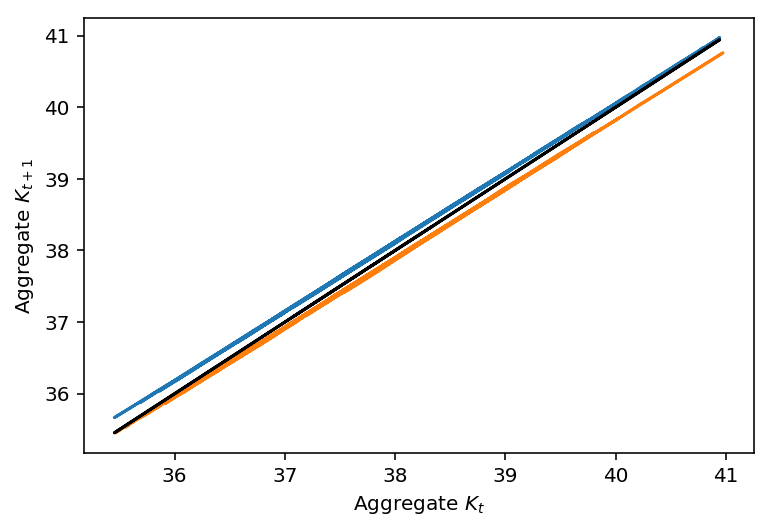

In [109]:
# Agg Today
km_t = np.delete(km_ts, -1, 0)
km_t1 = np.delete(km_ts, 0, 0)
ag_shock = np.delete(ag_shock, -1, 0)

# Agg good today
igood = np.where(ag_shock==1)[0]
# Agg bad today
ibad = np.where(ag_shock==0)[0]

plt.plot(km_t[igood], km_t1[igood])
plt.plot(km_t[ibad], km_t1[ibad])
plt.plot(km_t[igood], km_t[igood], color = 'k')
plt.xlabel(r'Aggregate $K_t$')
plt.ylabel(r'Aggregate $K_{t+1}$')
plt.show()

In [110]:
B, km_ts, k_cross, k_prime, c, id_shock, ag_shock = solve_ALM_1(B)
print(B)

0.01330487842376364
[[0.1242 0.9657]
 [0.135  0.9638]]


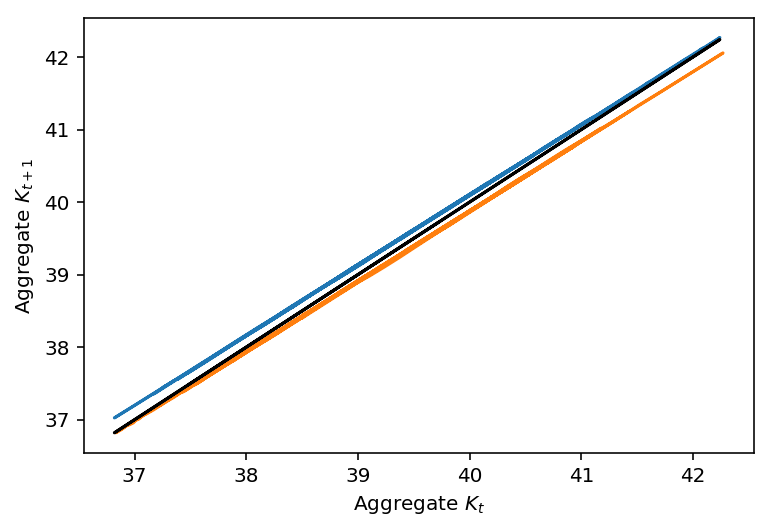

In [111]:
# Agg Today
km_t = np.delete(km_ts, -1, 0)
km_t1 = np.delete(km_ts, 0, 0)
ag_shock = np.delete(ag_shock, -1, 0)

# Agg good today
igood = np.where(ag_shock==1)[0]
# Agg bad today
ibad = np.where(ag_shock==0)[0]

plt.plot(km_t[igood], km_t1[igood])
plt.plot(km_t[ibad], km_t1[ibad])
plt.plot(km_t[igood], km_t[igood], color = 'k')
plt.xlabel(r'Aggregate $K_t$')
plt.ylabel(r'Aggregate $K_{t+1}$')
plt.show()